In [ ]:
# Clustering Lab: K-Means vs K-Medoids on Wine Dataset
#Name: Nischal Joshi
#Course: MSCS 634 Advanced Data Mining and Big Data 
#Lab: Lab Assignment 3

In [25]:
# Step 1: Preparing and Loading the Data
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load Wine dataset
wine = load_wine()
X = wine.data
y = wine.target

# Convert to DataFrame for easier exploration
df = pd.DataFrame(X, columns=wine.feature_names)
df['target'] = y

# Basic data exploration
print("First 5 rows of the dataset:")
print(df.head())
print("\nClass distribution:")
print(df['target'].value_counts())
print("\nFeature names:")
print(wine.feature_names)

# Standardize features using z-score normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

First 5 rows of the dataset:
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  

In [27]:
# Step 2: Implementing K-Means Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

# KMeans with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Calculate performance metrics
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_ari = adjusted_rand_score(y, kmeans_labels)

print("\nK-Means Results:")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Adjusted Rand Index: {kmeans_ari:.4f}")



K-Means Results:
Silhouette Score: 0.2849
Adjusted Rand Index: 0.8975


In [29]:
# Step 3: Implementing K-Medoids Clustering
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Initialize medoids using k-means++ centers for better initialization
kmeans_plus = KMeans(n_clusters=k, init='k-means++', random_state=42).fit(X_scaled)
initial_medoids = [np.argmin(np.linalg.norm(X_scaled - center, axis=1)) for center in kmeans_plus.cluster_centers_]

# Run K-Medoids clustering
kmedoids_instance = kmedoids(X_scaled.tolist(), initial_medoids, data_type='points', ccore=False)
kmedoids_instance.process()
kmedoids_clusters = kmedoids_instance.get_clusters()
kmedoids_medoids = kmedoids_instance.get_medoids()

# Create labels array from clusters for metric calculations
kmedoids_labels = np.empty(len(X_scaled), dtype=int)
for cluster_idx, cluster in enumerate(kmedoids_clusters):
    for data_idx in cluster:
        kmedoids_labels[data_idx] = cluster_idx

# Calculate performance metrics
kmedoids_silhouette = silhouette_score(X_scaled, kmedoids_labels)
kmedoids_ari = adjusted_rand_score(y, kmedoids_labels)

print("\nK-Medoids Results:")
print(f"Silhouette Score: {kmedoids_silhouette:.4f}")
print(f"Adjusted Rand Index: {kmedoids_ari:.4f}")


K-Medoids Results:
Silhouette Score: 0.2676
Adjusted Rand Index: 0.7411


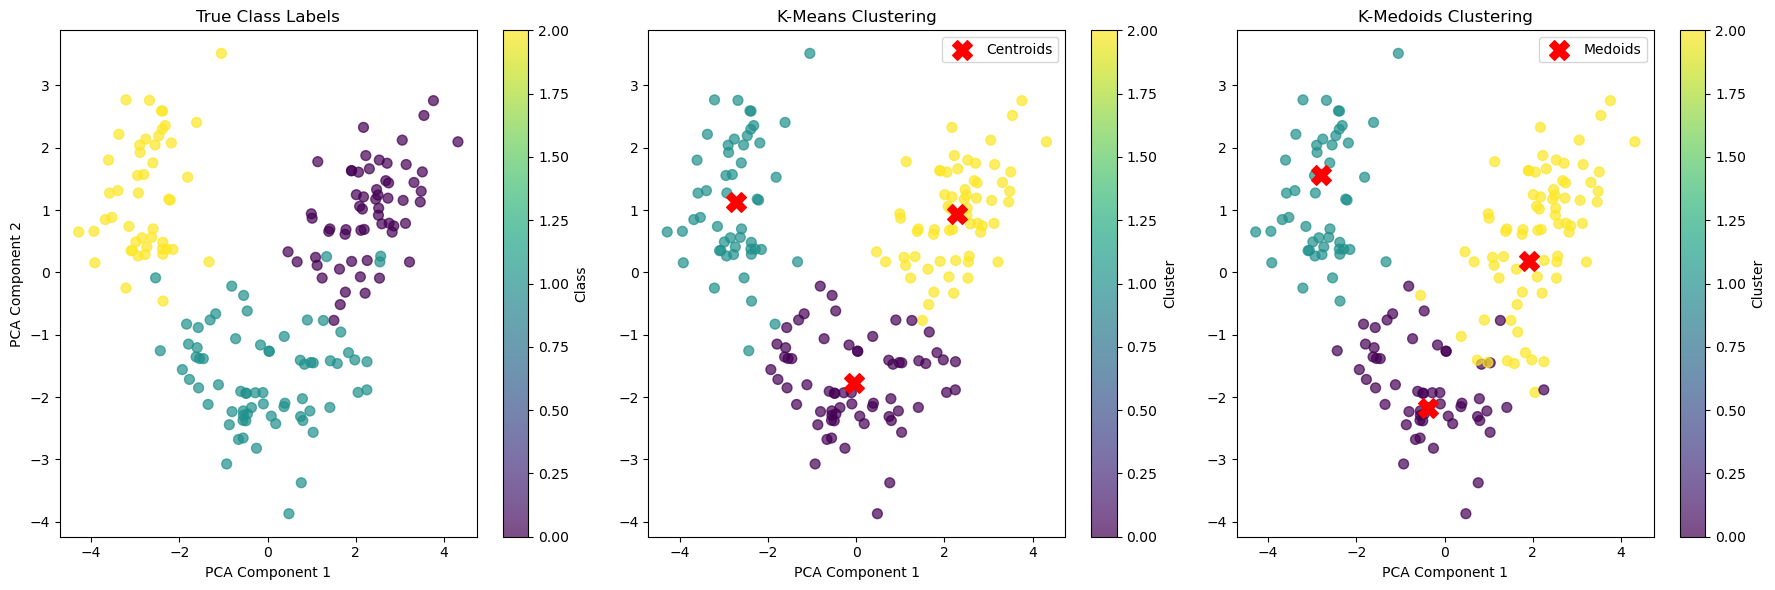


Comparison of Clustering Performance:
Metric                    K-Means    K-Medoids 
Silhouette Score          0.2849     0.2676
Adjusted Rand Index       0.8975     0.7411


In [31]:
# Step 4: Visualizing and Comparing Results
from sklearn.decomposition import PCA

# Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Get KMeans centroids and KMedoids medoids in PCA space
kmeans_centroids_pca = pca.transform(kmeans.cluster_centers_)
kmedoids_medoids_pca = X_pca[kmedoids_medoids]

# Create figure with 3 subplots: True labels, K-Means, and K-Medoids
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# True labels plot
scatter_true = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', marker='o', s=50, alpha=0.7)
axes[0].set_title('True Class Labels')
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')
plt.colorbar(scatter_true, ax=axes[0], label='Class')

# KMeans plot
scatter_kmeans = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', marker='o', s=50, alpha=0.7)
axes[1].scatter(kmeans_centroids_pca[:, 0], kmeans_centroids_pca[:, 1], c='red', marker='X', s=200, label='Centroids')
axes[1].set_title('K-Means Clustering')
axes[1].set_xlabel('PCA Component 1')
axes[1].legend()
plt.colorbar(scatter_kmeans, ax=axes[1], label='Cluster')

# KMedoids plot
scatter_kmedoids = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=kmedoids_labels, cmap='viridis', marker='o', s=50, alpha=0.7)
axes[2].scatter(kmedoids_medoids_pca[:, 0], kmedoids_medoids_pca[:, 1], c='red', marker='X', s=200, label='Medoids')
axes[2].set_title('K-Medoids Clustering')
axes[2].set_xlabel('PCA Component 1')
axes[2].legend()
plt.colorbar(scatter_kmedoids, ax=axes[2], label='Cluster')

plt.tight_layout()
plt.show()

# Print comparison of metrics
print("\nComparison of Clustering Performance:")
print(f"{'Metric':<25} {'K-Means':<10} {'K-Medoids':<10}")
print(f"{'Silhouette Score':<25} {kmeans_silhouette:.4f} {kmedoids_silhouette:>10.4f}")
print(f"{'Adjusted Rand Index':<25} {kmeans_ari:.4f} {kmedoids_ari:>10.4f}")

In [ ]:
# Clustering and Analysis Comparison: 
# Question 1: Which algorithm produced better-defined clusters?
# Depending upon the Silhouette Score and Adjusted Rand Index (ARI), K-Means provided slightly better and accurate clusters than K-Medoids:
# The Silhouette score and ARI are as follows:

# K-Means Silhouette Score: 0.2849
# K-Medoids Silhouette Score: 0.2676
# K-Means ARI: 0.8975
# K-Medoids ARI: 0.7411

# The higher Silhouette Score shows that K-means clusters are better separated. 
# The higher ARI shows that clusters in K-Means align more closely with the true wine class label.

# What differences do you observe in cluster shapes or positioning?
# As expected, the K-Means algorithm creates tighter and more regularly shaped clusters since it is optimizing for variance minimization around centroids.
# K-Medoids, on the other hand, form slightly less regular clusters because it choose actual data points as medoids, which can lead to more natural but slightly less centered clustering.
# For PCA scatter plots, both algorithms identify similar clusters, but K-Means centroids are centrally located, while K-Medoids medoids are off-center in certain regions, affecting overall performance.

# K-Means is better when:
# The data is well-scaled, spherical, and contains few outliers.
# A faster computation and higher performance on large data is required.
# Cluster centers as averages (means) are meaningful.


# K-Medoids is better when:
# The dataset contains a lot of outliers or noise, since medoids are actual points and are less affected by them.
# An interpretable cluster centers that relate to real data points is required.
# The distance measure is non-Euclidean, or the mean is not meaningful (e.g., for categorical data=